In [184]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate
from scipy.integrate import quad, quad_explain
from scipy.stats import binned_statistic
import camb

%matplotlib inline

In [185]:
# for plots
import seaborn as sns
sns.set_style("ticks", {'axes.grid': True, 'grid.linestyle': '--'})
sns.set_context("poster")
sns.set_palette("Set2")

In [26]:
# cosmology
pars = camb.CAMBparams()

In [27]:
# planck 2015 TT+lowP+lensing
# https://www.aanda.org/articles/aa/full_html/2016/10/aa25830-15/aa25830-15.html
pars.set_cosmology(ombh2=0.02226, 
                   omch2=0.1186,
                   cosmomc_theta=1.04103/100,
                   H0 = None,
                   tau = 0.066)

pars.InitPower.set_params(ns=0.9677,
                          As=2.139e-9)

pars.set_matter_power(redshifts=[0])

#results
results = camb.get_results(pars)

In [28]:
# use these two lines to compare with Planck derived parameters (Table 4 of 2015 parameters
# paper)
# results.get_derived_params()
# results.get_sigma8()

In [177]:
# linear matter power spectrum
kh, z, [pk] = results.get_matter_power_spectrum(minkh=0.001, maxkh=100,npoints=1000)
# creating a P(k) function by interpolating camb output
pk_k = interpolate.interp1d(kh,pk, kind='cubic')

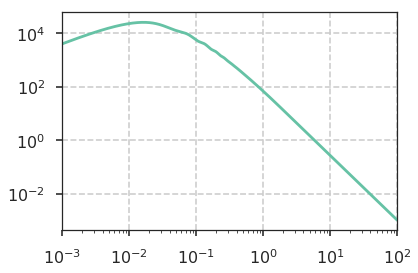

In [186]:
plt.loglog(kh, pk_k(kh))
plt.xlim(kh.min(),kh.max())
plt.show()

In [187]:
quad_explain()


    Compute a definite integral.

    Integrate func from `a` to `b` (possibly infinite interval) using a
    technique from the Fortran library QUADPACK.

    Parameters
    ----------
    func : {function, scipy.LowLevelCallable}
        A Python function or method to integrate.  If `func` takes many
        arguments, it is integrated along the axis corresponding to the
        first argument.

        If the user desires improved integration performance, then `f` may
        be a `scipy.LowLevelCallable` with one of the signatures::

            double func(double x)
            double func(double x, void *user_data)
            double func(int n, double *xx)
            double func(int n, double *xx, void *user_data)

        The ``user_data`` is the data contained in the `scipy.LowLevelCallable`.
        In the call forms with ``xx``,  ``n`` is the length of the ``xx`` 
        array which contains ``xx[0] == x`` and the rest of the items are
        numbers contained in the ``a

In [196]:
# correlation function
def xi(r,kmin,kmax,pk):
    int_ = lambda k: k**2 * pk(k) * np.sin(k*r)/(2*(np.pi**2)*k*r)
    xir =  quad(int_,kmin, kmax,limit=1000)[0]
    return xir

In [197]:
%%timeit 
xi(95,kmin,kmax,pk_k)

1 loop, best of 3: 1.79 s per loop


In [198]:
kmin, kmax = kh.min(), kh.max()
#kmin, kmax = 0.001, 100

In [199]:
def xi_binned(r, xi, bin_size=3):
    """r: array of positions to evalue correlation function over"""
    bins = np.arange(r.min(),r.max()+bin_size,bin_size)
    bin_means, bin_edges = binned_statistic(r,xi,statistic='mean',bins=bins)[:2]
    bin_centers = bin_edges[1:] - bin_size/2
    return bin_centers, bin_means

/home/marcio/anaconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (1000) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


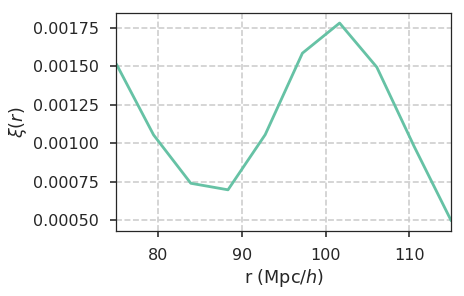

In [200]:
r = np.linspace(75,115,10)
xi_r = [xi(i, kmin,kmax, pk_k) for i in r]

plt.plot(r, xi_r, label=r'$\xi(r)$')
#plt.plot(*xi_binned(r,xi_r), label=r'$\xi(r)$ binned')

#plt.ylim(-0.001,0.004)
plt.xlim(r.min(),r.max())
#plt.legend()

plt.ylabel(r'$\xi(r)$')
plt.xlabel(r'r (${\rm Mpc}/h$)')

# plt.savefig('Figures/xi_r.png', dpi=300, bbox_inches='tight',
#            facecolor='w', edgecolor='w')
plt.show()

In [112]:
# polynomial fit
class Polyfit:
    def __init__(self,order):
        self.order = order
    def do_fit(self, r, xi):
        self.coeffs = np.polyfit(r, xi, self.order)
    def get_fit(self, r):
        return np.dot(r**np.arange(self.order+1)[::-1],self.coeffs)

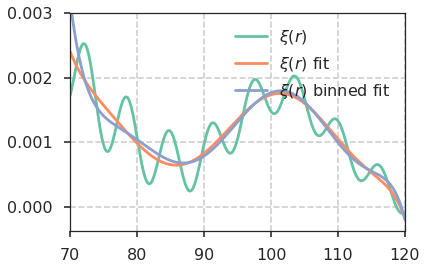

In [113]:
order = 7

# straight from integral
r = np.linspace(70,120,500)
xi_r = [xi(i, kh, pk) for i in r]

# fitting on integral result
pfit = Polyfit(order)
pfit.do_fit(r,xi_r)
xi_fit = [pfit.get_fit(i) for i in r]

# binning integral result
r_bin, xi_bin = xi_binned(r,xi_r)
# fitting on binned data
pfit = Polyfit(order)
pfit.do_fit(r_bin,xi_bin)
xi_fb = [pfit.get_fit(i) for i in r]

plt.plot(r, xi_r, label=r'$\xi(r)$')
plt.plot(r, xi_fit, label=r'$\xi(r)$ fit')
plt.plot(r, xi_fb, label=r'$\xi(r)$ binned fit')


plt.ylim(ymax=0.003)
plt.legend(loc='upper right')
plt.xlim(r.min(),r.max())
plt.show()